## This is a notebook to train a Bayesian neural network with HMC.

Bayesian neural networks can quantify uncertainties in their prediction. In this notebook a Bayesian neural network is trained with HMC sampling to learn the function $$ y = 0.4 \sin(4x) + 0.5 \cos(12x) $$
A zero mean Gaussian random noise with standard deviation $\sigma = 0.05$ is added to the train data. Both the aleatoric (noise in the data) and the epistemic (model uncertainty) uncertaintes are quantified.

### Import necessary tools
This notebook uses code from the [Hamiltorch](https://github.com/AdamCobb/hamiltorch) which is a pytorch based library to perform HMC in Bayesian neural networks. In the following cell we import the necessary libraries to set up the environment to run the code.

In [1]:
import torch
import matplotlib.pyplot as plt
import samplers
import torch.nn as nn
import torch.nn.functional as F
import util
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(0);

### Build the Neural network
Now, we build the neural network. The neural network consists of 3 hidden layers with 20 neurons and ReLu activation function.

In [3]:
width = 20
net = nn.Sequential(
    nn.Linear(1, width),
    nn.ReLU(),
    nn.Linear(width, width),
    nn.ReLU(),
    nn.Linear(width, width),
    nn.ReLU(),
    nn.Linear(width, width),
    nn.ReLU(),
    nn.Linear(width, 1),
)

### Define the data
Once the libraries are loaded, we build the dataset to train and validate.

In [2]:
N_tr = 20
N_val = 300


x_val = torch.linspace(-1,1,N_val).view(-1,1)
y_val = (0.4*torch.sin(4*x_val) + 0.5*torch.cos(12*x_val)).view(-1,1)

x_train = torch.cat((torch.linspace(-1, -0.2, int(N_tr/2)),torch.linspace(0.2, 1, int(N_tr/2)))).reshape(-1, 1)
y_train = (0.4*torch.sin(4*x_train) + 0.5*torch.cos(12*x_train)) + torch.randn_like(x_train)*0.05

x_train = x_train.to(device)
y_train = y_train.to(device)

x_val = x_val.to(device)
y_val = y_val.to(device)


### Set up HMC
Next, we initalize the parameters of the neural network to perform HMC and define the prior distribution of parameters. In this example the prior distributions are assumed to be zero mean Gaussians with variance defined by the user. 

In [4]:
params_init = util.flatten(net).to(device).clone()

#define prior
tau_list = []
tau = 1. # prior variance
for w in net.parameters():
    tau_list.append(tau)
tau_list = torch.tensor(tau_list).to(device)

Here, we define the HMC parameters such as step size and number of leap frog steps and number of samples.

In [5]:
step_size = 5e-4 # Step size of the leap frog step
num_samples = 1000 #number of samples to draw from the posterior distribution
L = 30 # Number of leap frog steps
tau_out = 1/(0.05)**2 # precision parameter in the Gaussian log likelihood function

### Run HMC
With the parameters of the HMC and the neural network model defined, we can now run the HMC sampler to draw samples from the posterior distribution. For convenience, HMC sampling is already performed and the samples saved. The code below was used to perform HMC.

```python

params_hmc = samplers.sample_model(net, x_train, y_train, model_loss='regression',params_init=params_init, num_samples=num_samples,
                               step_size=step_size, num_steps_per_sample=L,tau_out=tau_out,normalizing_const=N_tr, tau_list=tau_list)
torch.save(params_hmc,'hmc_parameters.pt')

### Post process samples and make predictions
We define the number of burnin steps for the HMC samples. First 200 steps are eliminated while postprocessing the results of the HMC in this example. After removing the initial burnin steps, we predic the outputs using the neural network with the parameters obtained from HMC and plot the results.

In [7]:
params_hmc = torch.load('hmc_parameters.pt')
burn = 200
pred_list, log_prob_list = samplers.predict_model(net, x=x_val, y=y_val, model_loss='regression', samples=params_hmc[burn:], tau_out=tau_out, tau_list=tau_list)

print('\nExpected MSE: {:.2f}'.format(((pred_list.mean(0) - y_val)**2).mean()))


Expected MSE: 0.07


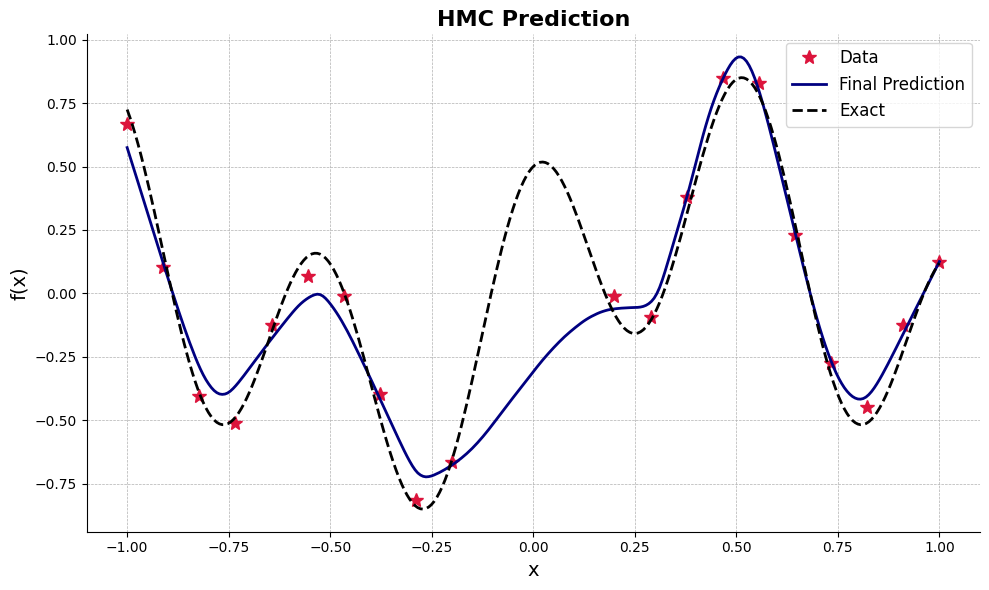

In [8]:
pred = pred_list.mean(0)
# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    x_train.detach().numpy(),
    y_train.detach().numpy(), '*',
    label="Data", color='crimson', markersize=10
)
ax.plot(
    x_val.detach().numpy(),
    pred.detach().numpy(),
    label="Final Prediction",
    color='navy', linewidth=2
)
ax.plot(
    x_val.detach(), y_val.detach(),
    label="Exact",
    color="black",
    linestyle="dashed",
    linewidth=2
)

# Customize the plot
ax.set_title("HMC Prediction", fontsize=16, fontweight='bold')
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("f(x)", fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Improve the layout
plt.tight_layout()

# Show the plot
plt.show()

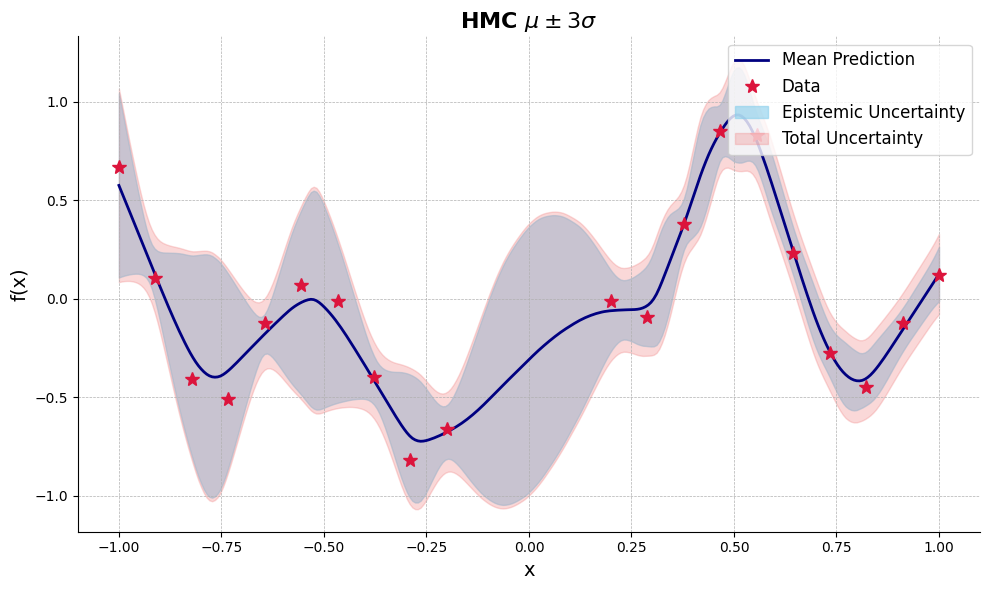

In [9]:
sigma = pred_list.std(0).detach()
total_sigma = torch.sqrt(sigma**2 + 0.05**2).detach()
mu = pred.detach()

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the mean prediction
ax.plot(x_val, mu, label="Mean Prediction", color='navy', linewidth=2)

# Plot the data points
ax.plot(
    x_train.detach().numpy(),
    y_train.detach().numpy(), '*',
    label="Data", color='crimson', markersize=10
)

# Fill the uncertainties
ax.fill_between(
    x_val.view(-1).detach(), mu.view(-1) - (3 * sigma.view(-1)), mu.view(-1) + (3 * sigma.view(-1)), 
    label="Epistemic Uncertainty", color='skyblue', alpha=0.6
)
ax.fill_between(
    x_val.view(-1).detach(), mu.view(-1) - (3 * total_sigma.view(-1)), mu.view(-1) + (3 * total_sigma.view(-1)), 
    label="Total Uncertainty", color='lightcoral', alpha=0.3
)

# Customize the plot
ax.set_title("HMC $\mu \pm 3\sigma$", fontsize=16, fontweight='bold')
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("f(x)", fontsize=14)
ax.legend(loc='upper right', fontsize=12)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Improve the layout
plt.tight_layout()

# Show the plot
plt.show()